In [1]:
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import torch
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import seaborn as sns
sns.set_theme()
sns.set_context('talk', )

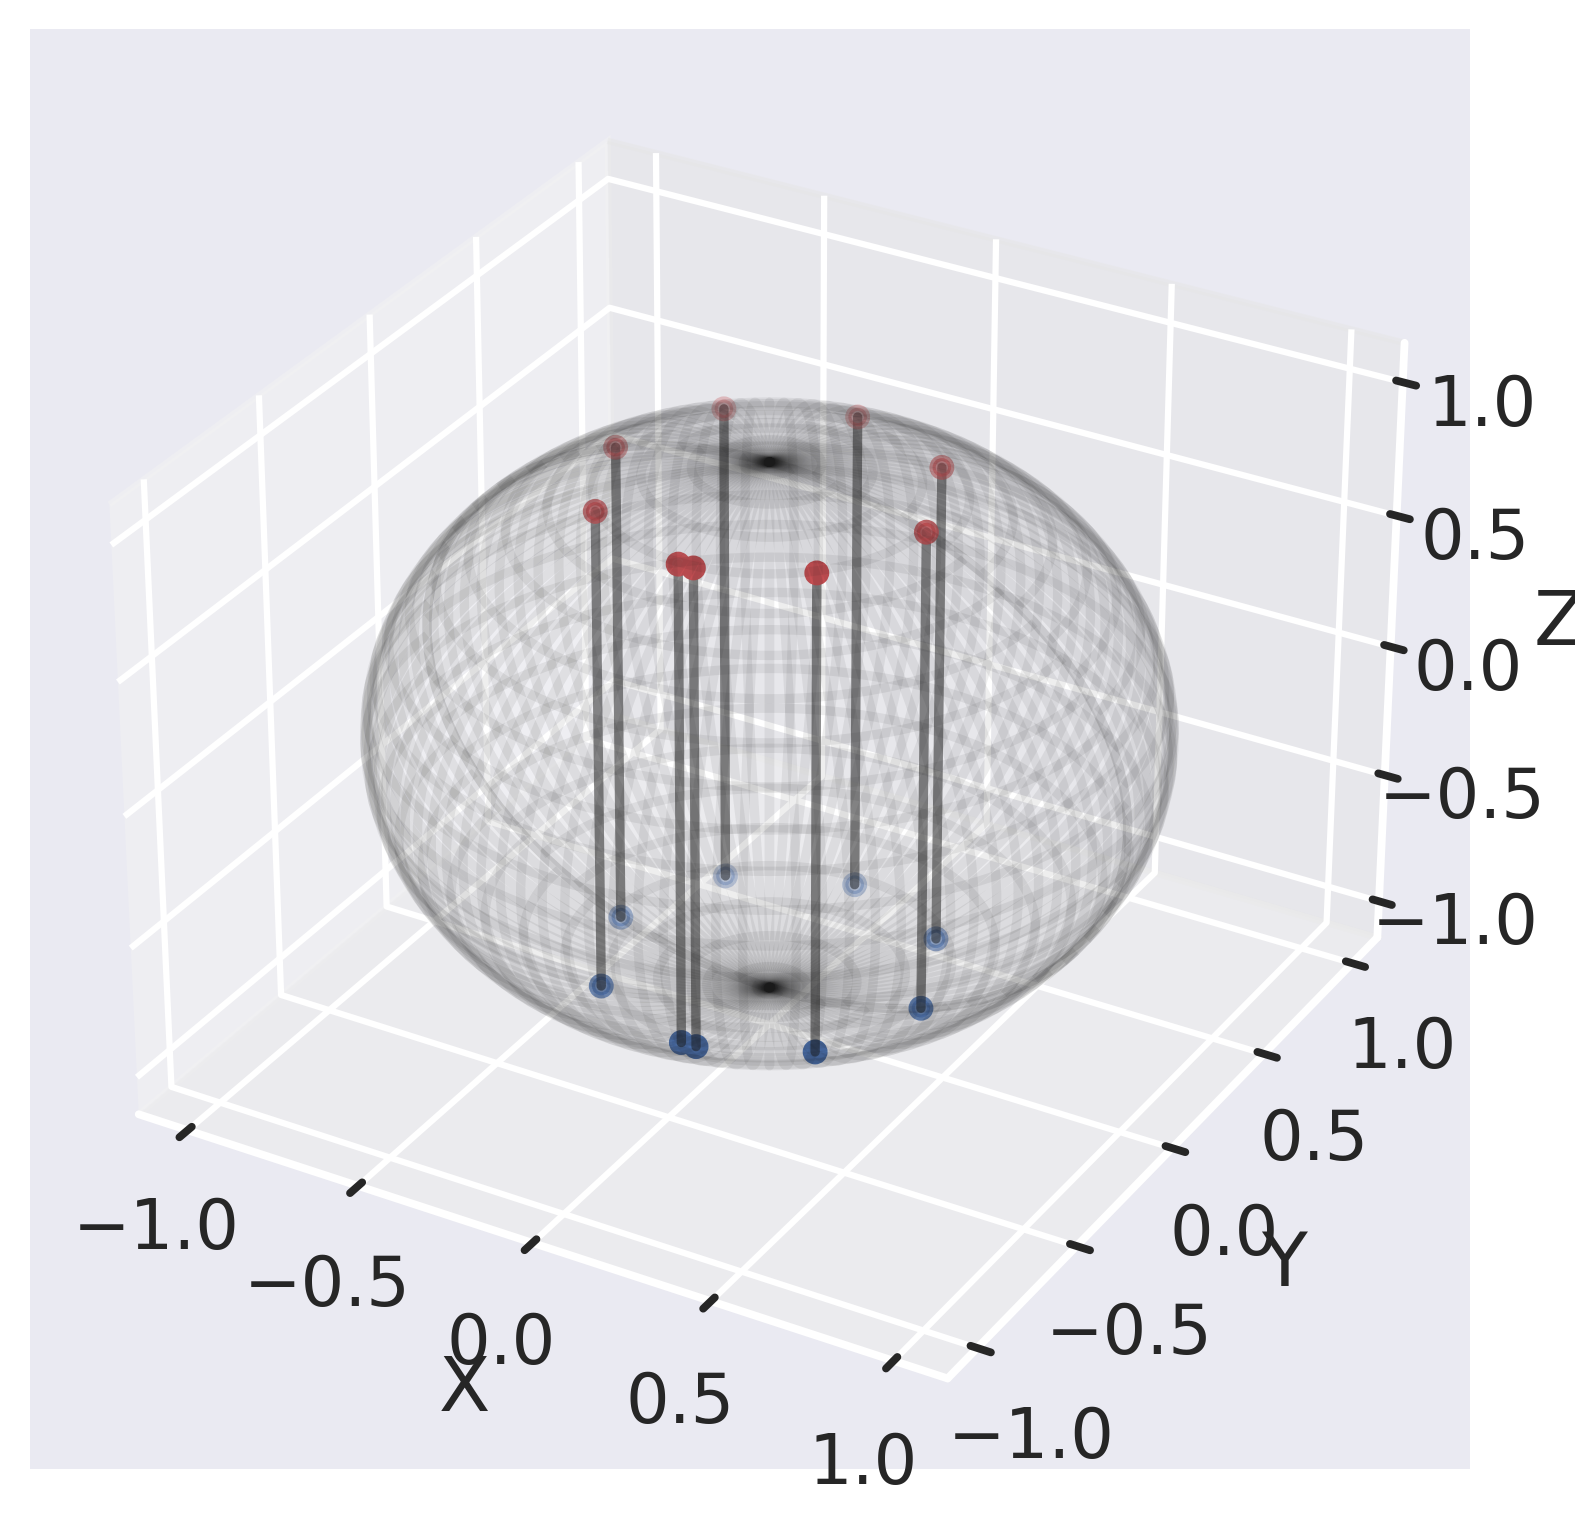

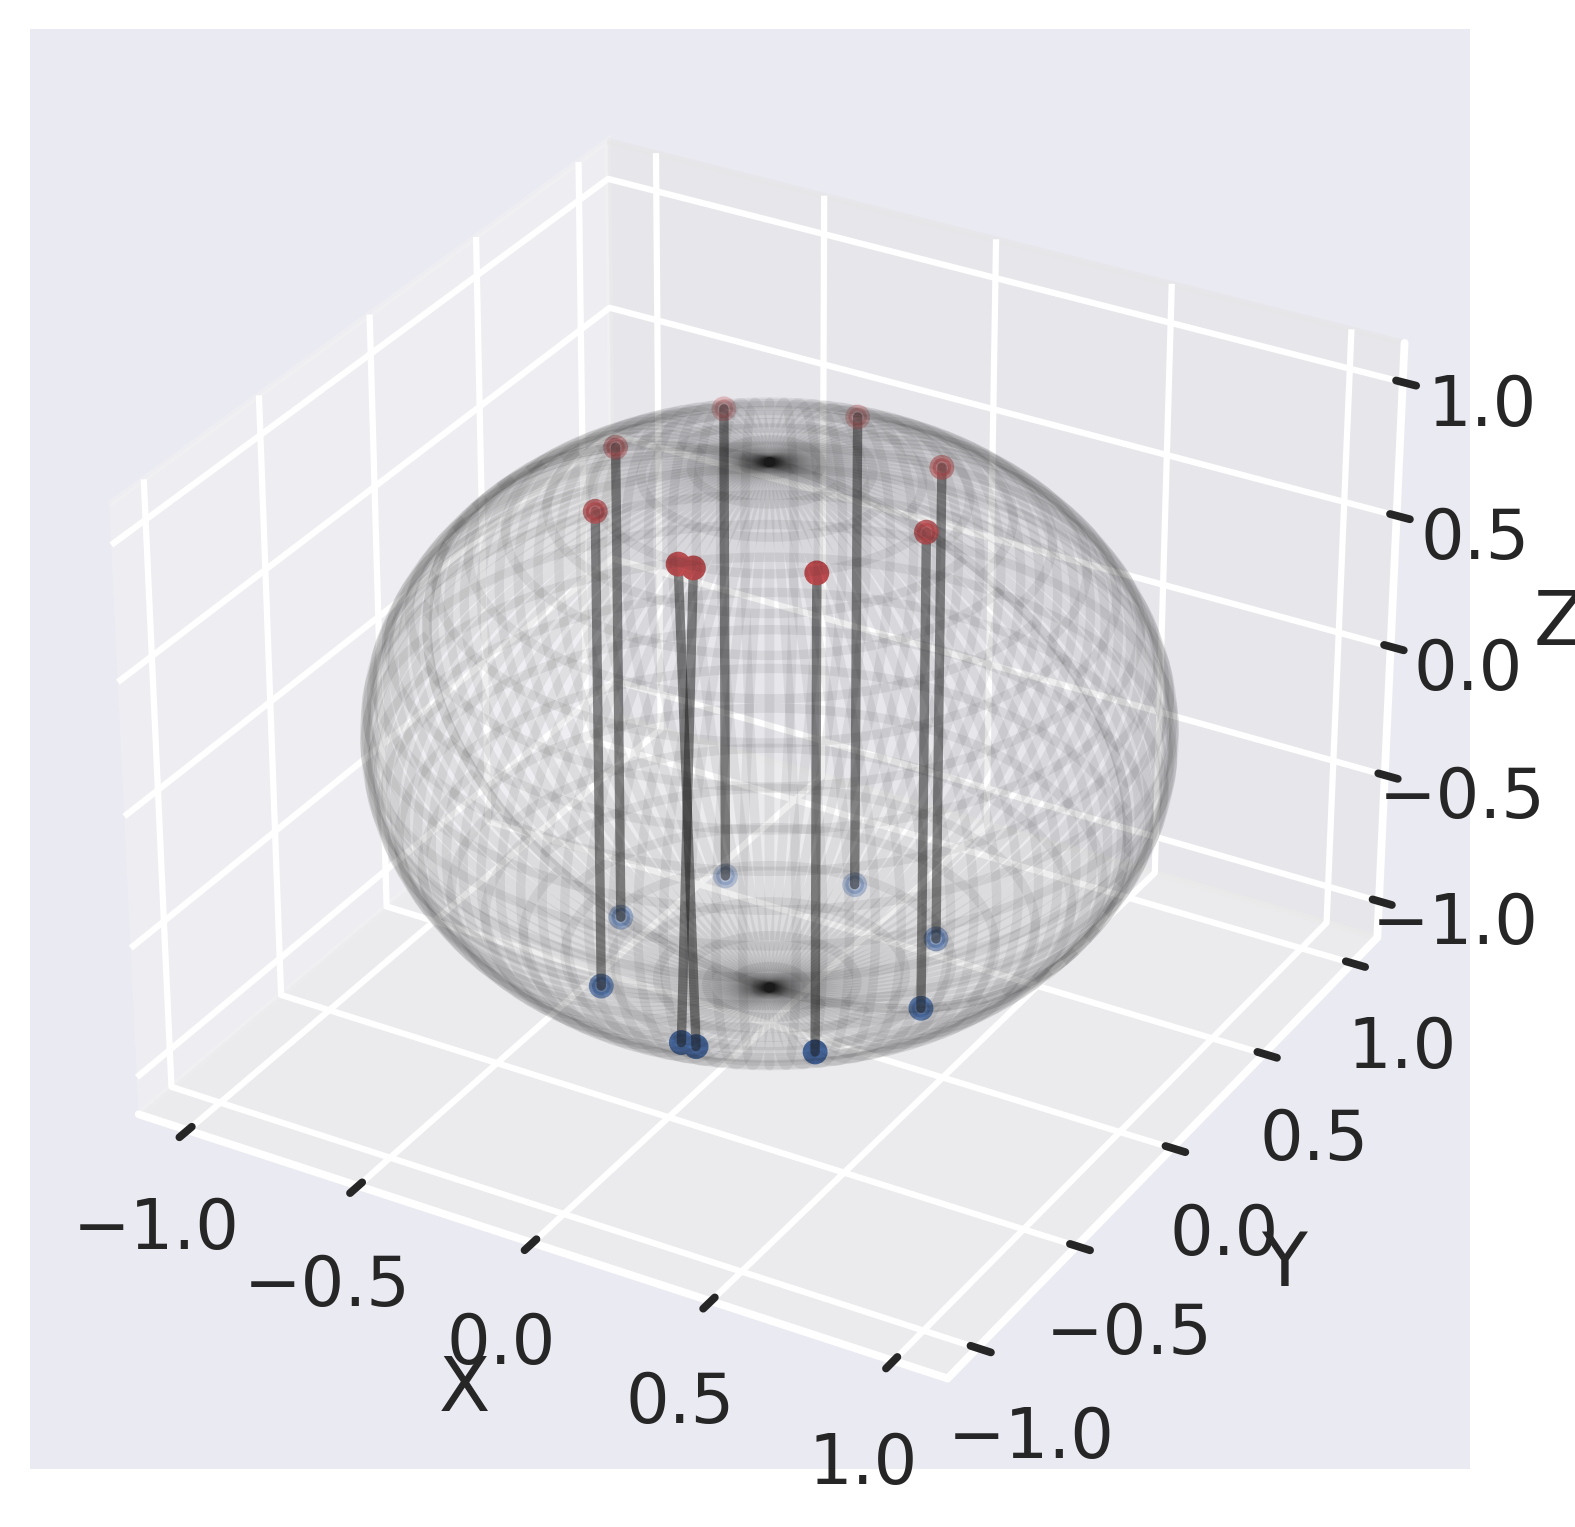

In [2]:
def init_points(z):
    a = (1 - z * z) ** 0.5 
    b = ((1 - z * z) / 2) ** 0.5
    theta = 0.03 * np.pi + 1.5 * np.pi
    points1 = torch.tensor([(a, 0, z), (-a, 0, z), (0, a, z), (0, -a, z), (b, b, z), (-b, b, z), (b, -b, z), (-b, -b, z), [np.cos(theta) * a, np.sin(theta) * a, z]]).float()
    points2 = torch.tensor([(a, 0, -z), (-a, 0, -z), (0, a, -z), (0, -a, -z), (b, b, -z), (-b, b, -z), (b, -b, -z), (-b, -b, -z), [np.cos(theta) * a, np.sin(theta) * a, -z]]).float()
    return points1, points2

def vis_features_3d(image_features, text_features, swap_labels=False):
    fig = plt.figure()
    ax = Axes3D(fig)

    # draw a 3D sphere
    u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100))
    x = np.sin(u) * np.cos(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(u)
    ax.plot_wireframe(x, y, z, color='k', alpha=0.07)

    features_3d = torch.cat([image_features, text_features], dim=0).numpy()

    ax.scatter(features_3d[:len(image_features), 0], features_3d[:len(image_features), 1], features_3d[:len(image_features), 2], c='r', label='image')
    ax.scatter(features_3d[len(image_features):, 0], features_3d[len(image_features):, 1], features_3d[len(image_features):, 2], c='b', label='text')
    
    # draw a line between the two sets of points
    connections = {i: i + len(image_features) for i in range(len(image_features))}
    if swap_labels: connections[3], connections[8] = connections[8], connections[3]
    for i in range(len(image_features)):
        ax.plot3D([features_3d[i, 0], features_3d[connections[i], 0]], [features_3d[i, 1], features_3d[connections[i], 1]], [features_3d[i, 2], features_3d[connections[i], 2]], 'k', alpha=0.5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.add_axes(ax)

def svd(X, n_components=2):
    U, S, Vt = np.linalg.svd(X)
    return U[:, :n_components] * S[:n_components]

def vis_features(image_features, text_features, swap_labels=False):
    features_2d = svd(torch.cat([image_features, text_features], dim=0).numpy())
    plt.scatter(features_2d[:len(image_features), 0], features_2d[:len(image_features), 1], c='r', label='image', alpha=0.5)
    plt.scatter(features_2d[len(image_features):, 0], features_2d[len(image_features):, 1], c='b', label='text', alpha=0.5)
    # draw connections between the two sets of points
    connections = {i: i + len(image_features) for i in range(len(image_features))}
    if swap_labels: connections[3], connections[8] = connections[8], connections[3]
    for i in range(len(image_features)):
        plt.plot([features_2d[i, 0], features_2d[connections[i], 0]], [features_2d[i, 1], features_2d[connections[i], 1]], 'k', alpha=0.5)
    plt.xlabel('SVD1')
    plt.ylabel('SVD2')
    # plt.legend()
    plt.show()

def calc_loss(image_features, text_features, temperature, swap_labels=False):
    loss_func = torch.nn.CrossEntropyLoss()

    assert(len(image_features) == len(text_features))
    sim = image_features @ text_features.t()
    sim_adjusted = sim * temperature
    labels = torch.arange(len(image_features), dtype=torch.long)
    if swap_labels: labels[3], labels[8] = labels[8], labels[3]

    loss_img = loss_func(sim_adjusted, labels)
    loss_txt = loss_func(sim_adjusted.t(), labels)
    loss = (loss_img + loss_txt) / 2
    return loss

points1, points2 = init_points(z=0.90)
vis_features_3d(points1, points2, swap_labels=False)
vis_features_3d(points1, points2, swap_labels=True)

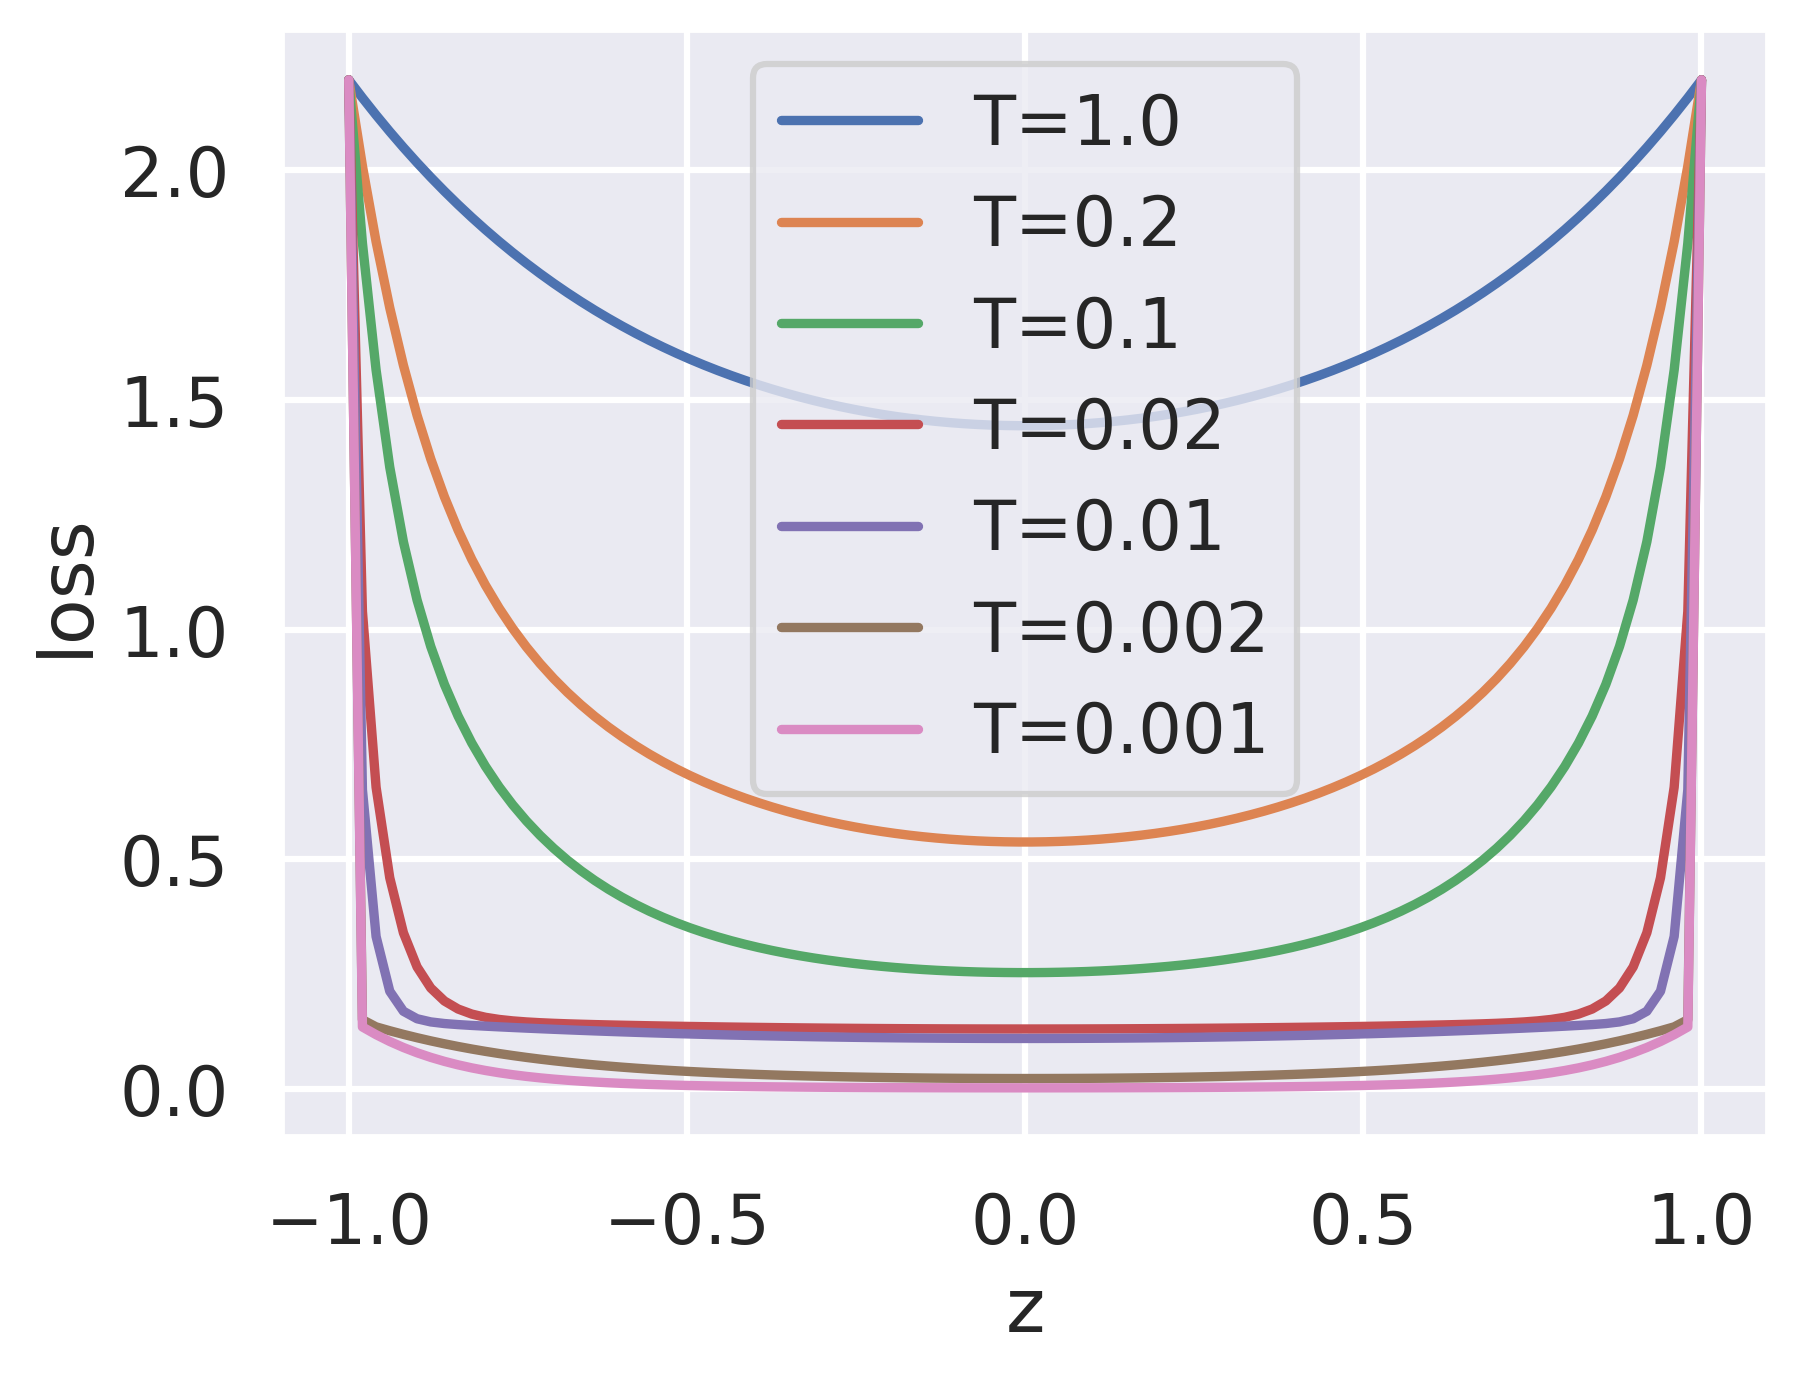

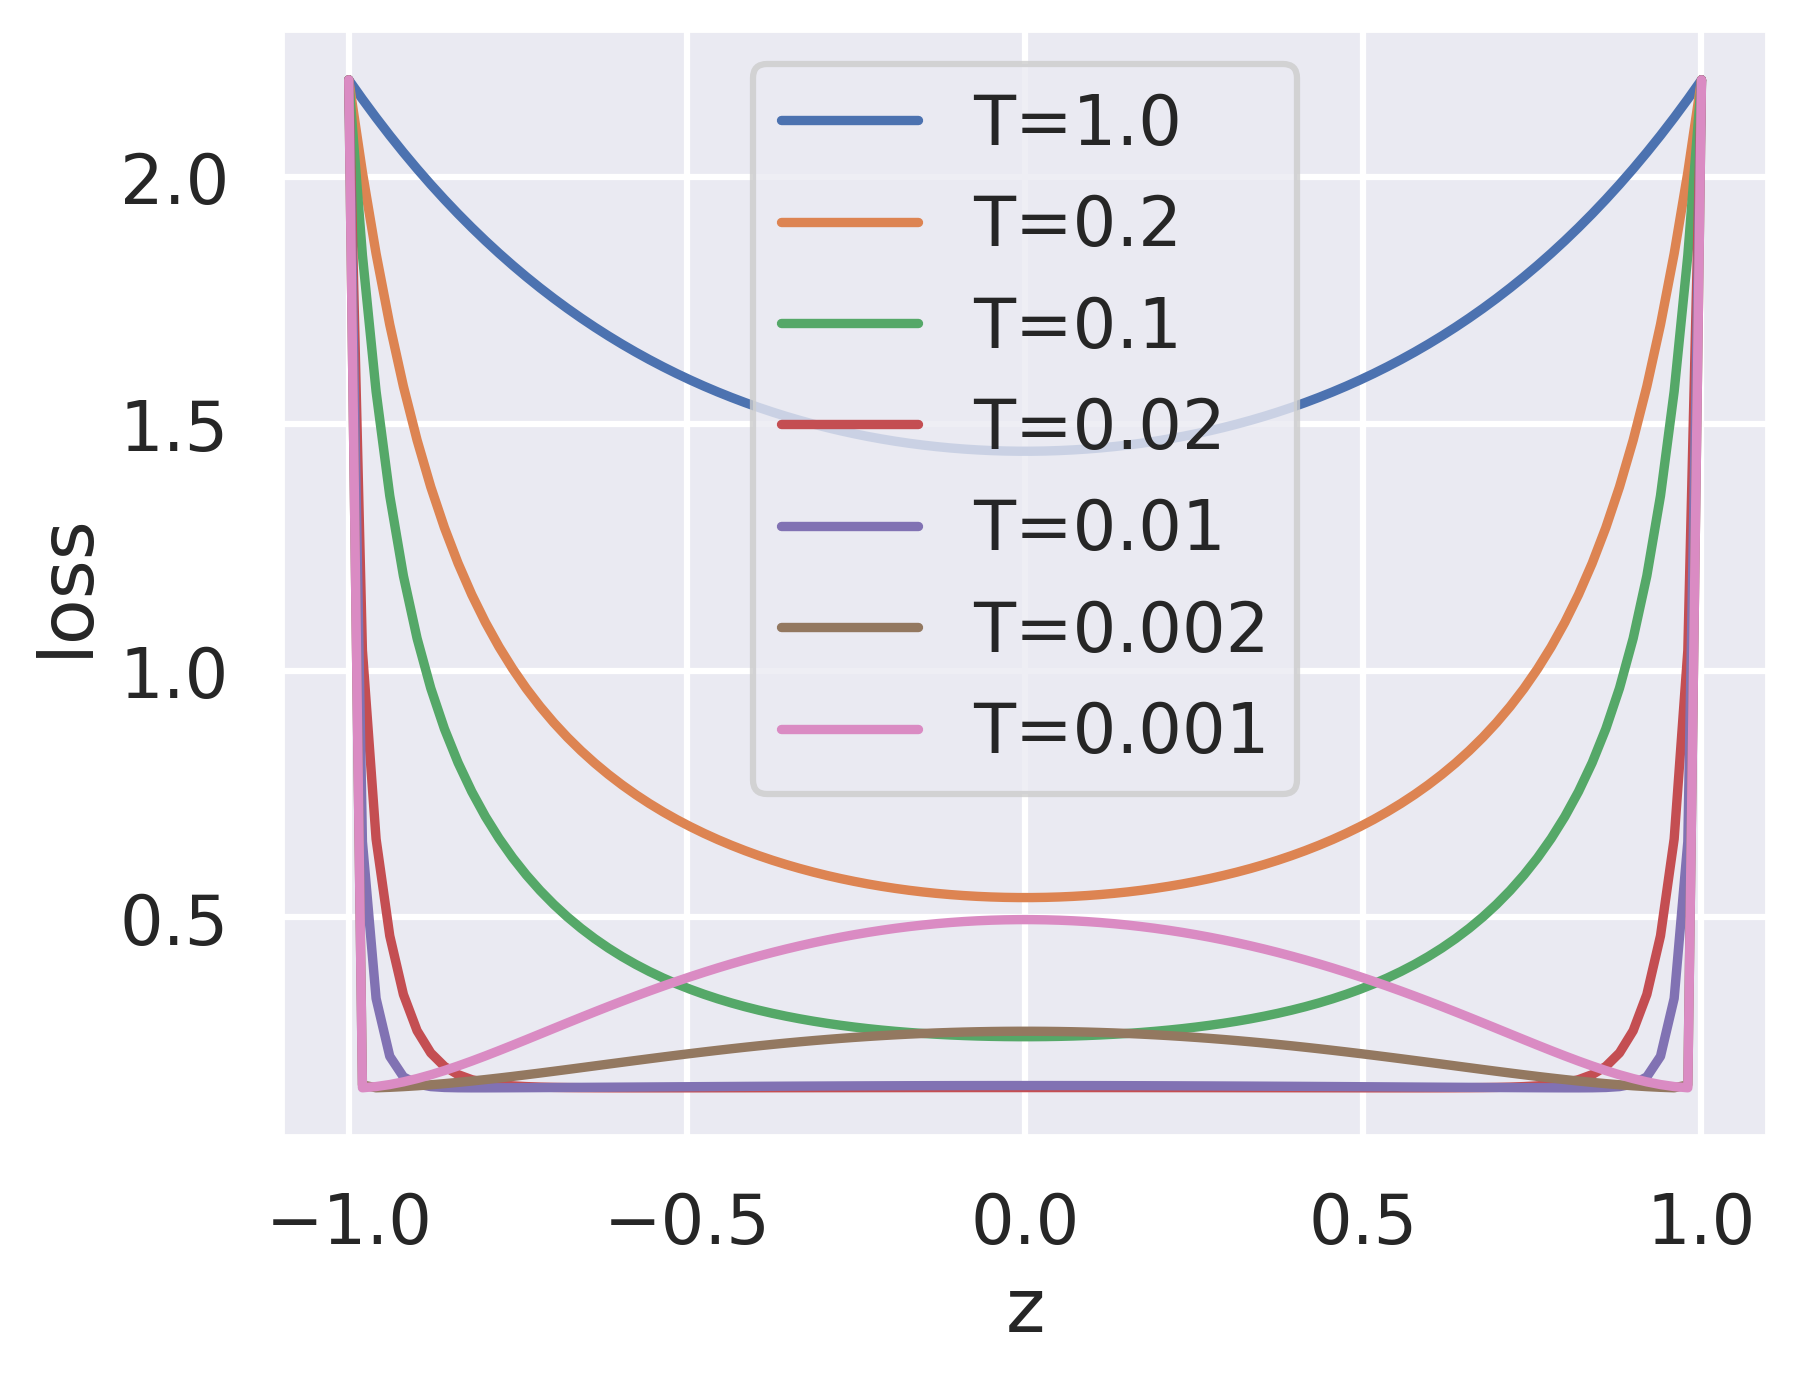

In [3]:
for swap_labels in [False, True]:
    losses = {}
    for temperature in [1, 5, 10, 50, 100, 500, 1000]:
        losses[temperature] = []
        for z in np.linspace(-1, 1, 100):
            points1, points2 = init_points(z)
            # vis_features_3d(points1, points2)
            loss = calc_loss(points1, points2, temperature, swap_labels)
            losses[temperature].append(loss)

    # plot losses on every temperature
    for temperature in [1, 5, 10, 50, 100, 500, 1000]:
        plt.plot(np.linspace(-1, 1, 100), losses[temperature], label=f'T={round(1/temperature, 3)}')
    plt.legend()
    plt.xlabel('z')
    plt.ylabel('loss')
    plt.show()